In [1]:
from collections import defaultdict

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
import wordcloud

from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from spacy import displacy



nltk.download("punkt")
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /home/rodion/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/rodion/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/rodion/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /home/rodion/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Let's load out data.

In [3]:
df = (
    pd.read_excel(
        "../data/raw/sentences_with_sentiment.xlsx",
        index_col="ID",
    ).rename(columns={
        "Sentence": "text",
        "Positive": "positive",
        "Negative": "negative",
        "Neutral": "neutral",
    })
)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 266 entries, 1 to 266
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      266 non-null    object
 1   positive  266 non-null    int64 
 2   negative  266 non-null    int64 
 3   neutral   266 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 10.4+ KB


So, we have 266 objects in the dataset.

In [5]:
df.head()

,text,positive,negative,neutral
ID,,,,
1,The results in 2nd line treatment show an ORR ...,1,0,0
2,The long duration of response and high durable...,1,0,0
3,The median OS time in the updated results exce...,0,0,1
4,"Therefore, the clinical benefit in 2nd line tr...",1,0,0
5,"The data provided in 1st line, although prelim...",1,0,0


Let's find out the balance of classes.

In [6]:
print("Number of positive samples:", df.positive.sum())
print("Number of negative samples:", df.negative.sum())
print("Number of neutral samples:", df.neutral.sum())

Number of positive samples: 160
Number of negative samples: 36
Number of neutral samples: 70


In [7]:
df["target"] = df.apply(lambda x: "positive" if x.positive else ("negative" if x.negative else "neutral"), axis=1)

In [10]:
classes = df.target.value_counts(normalize=True).index
percentages = df.target.value_counts(normalize=True).values

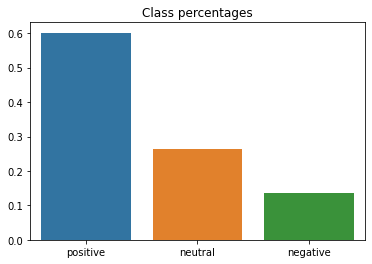

In [15]:
sns.barplot(x=classes, y=percentages)
plt.title("Сlass percentages");
plt.savefig("../reports/class_percentages.png", dpi=300)

We can see that the most represented class is positive and the most underrepresented class is negative. Therefore during the training we should carefully keep that balance in train-test split. And, also, we should use some suitable metric for an estimation of quality on imbalanced dataset.

## EDA part

Let's start our exploratory data analysis on some histogram on sentences lengths, number of tokens e.t.c.

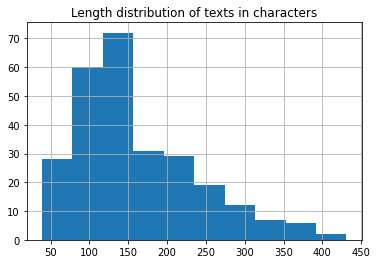

In [16]:
df.text.str.len().hist()
plt.title("Length distribution of texts in characters");
plt.savefig("../reports/character_lengths.png", dpi=200)

The plot shows that sentences range from 40 to 430 characters, most of them lie within range from 60 to 200.

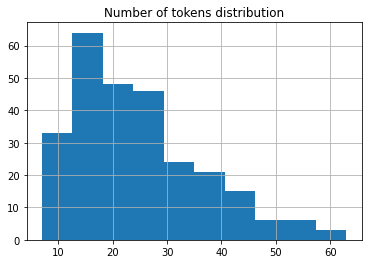

In [17]:
df.text.str.split().map(lambda x: len(x)).hist()
plt.title("Number of tokens distribution");
plt.savefig("../reports/num_tokens_distribution.png", dpi=200)

The plot shows that sentences range from 5 to 65 tokens. Most of them consist from 12 to 30 tokens.

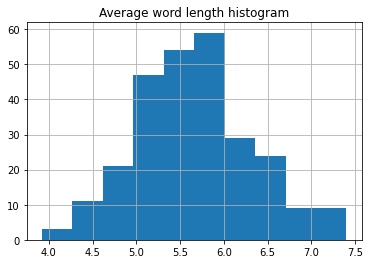

In [18]:
(
    df.text.str.split()
    .apply(lambda x : [len(i) for i in x])
    .map(lambda x: np.mean(x)).hist()
)
plt.title("Average word length histogram");

In [19]:
stoplist = set(nltk.corpus.stopwords.words("english"))

### Ngrams with stopwords

In [20]:
def get_top_ngram(corpus, n=None, top_words=10, stopwords=None):
    if stopwords is None:
        stopwords = []
    vec = CountVectorizer(ngram_range=(n, n), stop_words=stopwords).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top_words]

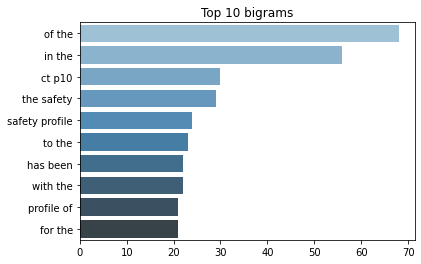

In [28]:
ngrams = get_top_ngram(df.text, n=2)
x, y = map(list, zip(*ngrams))
sns.barplot(x=y, y=x, orient="h", palette="Blues_d")
plt.title("Top 10 bigrams");

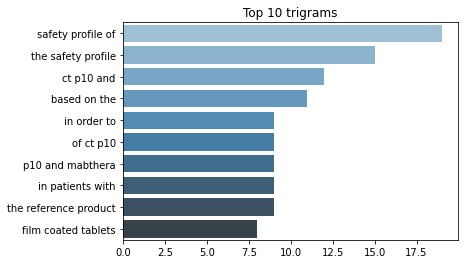

In [27]:
x, y = map(list, zip(*get_top_ngram(df.text, n=3)))
sns.barplot(x=y, y=x, orient="h", palette="Blues_d")
plt.title("Top 10 trigrams");

### Ngrams without stopwords

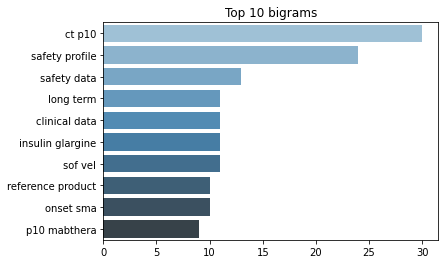

In [37]:
ngrams = get_top_ngram(df.text, n=2, stopwords=stoplist)
x, y = map(list, zip(*ngrams))
sns.barplot(x=y, y=x, orient="h", color=0, palette="Blues_d")
plt.title("Top 10 bigrams");
plt.savefig("../reports/top_10_bigrams.png", dpi=200, pad_inches=0.5, bbox_inches="tight")

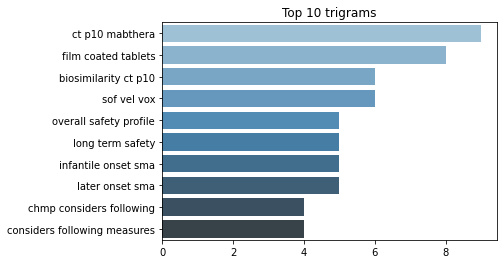

In [38]:
ngrams = get_top_ngram(df.text, n=3, stopwords=stoplist)
x, y = map(list, zip(*ngrams))
sns.barplot(x=y, y=x, orient="h", palette="Blues_d")
plt.title("Top 10 trigrams");
plt.savefig("../reports/top_10_trigrams.png", dpi=200, pad_inches=0.5, bbox_inches="tight")

### Word Cloud

In [39]:
corpus = df.text.str.split().values.tolist()

tokens_count = defaultdict(int)
for text in corpus:
    for word in text:
        if word in stoplist:
            tokens_count[word] += 1

In [40]:
def preprocess(texts_series, stopwords):
    corpus = []
    stem = nltk.PorterStemmer()
    lem = nltk.WordNetLemmatizer()
    for text in texts_series:
        words = [w for w in nltk.word_tokenize(text) if (w not in stopwords)]
        
        words = [lem.lemmatize(w).lower() for w in words if len(w) > 2]
        
        corpus.append(words)
    return corpus

corpus = preprocess(df.text, stoplist)

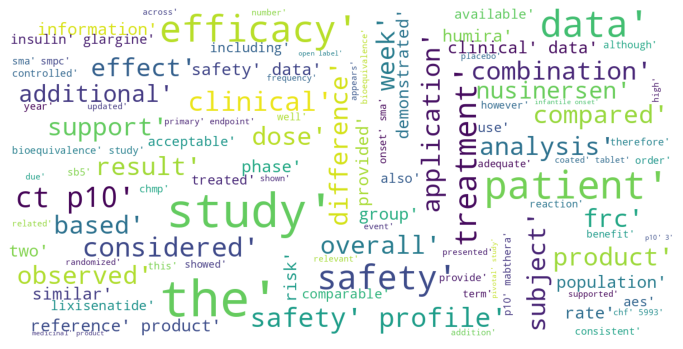

In [46]:
def show_wordcloud(data, stop_words):
    wordcloud_obj = wordcloud.WordCloud(
        background_color='white',
        stopwords=stop_words,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1,
    )
   
    cloud = wordcloud_obj.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(cloud)
    plt.show()
    return wordcloud_obj

fig = show_wordcloud(corpus, stoplist)
fig.to_file("../reports/wordcloud.png");

## NER entities

In [27]:
nlp = spacy.load("en_ner_bc5cdr_md")

In [44]:
text = df.iloc[16].text
doc = nlp(text)
displacy.render(doc, style="ent")

In [45]:
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

RMP 147 150 CHEMICAL


## Classification metrics with dummy classifier

Let's build a dummy classifier always predicting the majority class.

In [47]:
features = df.text
target = df.target

In [48]:
target_encoder = LabelEncoder()
ground_truth = target_encoder.fit_transform(target)
clf = DummyClassifier()
clf.fit(features, ground_truth)

DummyClassifier()

In [49]:
predict = clf.predict(features)

In [50]:
print("F1 score: %.2f" % f1_score(ground_truth, predict, average="macro"))
print("Precision score: %.2f" % precision_score(ground_truth, predict, average="macro"))
print("Recall score: %.2f" % recall_score(ground_truth, predict, average="macro"))

F1 score: 0.25
Precision score: 0.20
Recall score: 0.33


/home/rodion/.cache/pypoetry/virtualenvs/bayer-home-assignment-2zscisEv-py3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [60]:
print(classification_report(ground_truth, predict, target_names=target_encoder.classes_, zero_division=1))

              precision    recall  f1-score   support

    negative       1.00      0.00      0.00        36
     neutral       1.00      0.00      0.00        70
    positive       0.60      1.00      0.75       160

    accuracy                           0.60       266
   macro avg       0.87      0.33      0.25       266
weighted avg       0.76      0.60      0.45       266



In [20]:
target_encoder.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

Let's build a dummy classifier predicting a label accorging to prior distribution.

In [66]:
clf = DummyClassifier(strategy="stratified", random_state=8042022)
clf.fit(features, ground_truth)
predict = clf.predict(features)

In [67]:
print("F1 score: %.2f" % f1_score(ground_truth, predict, average="macro"))
print("Precision score: %.2f" % precision_score(ground_truth, predict, average="macro"))
print("Recall score: %.2f" % recall_score(ground_truth, predict, average="macro"))

F1 score: 0.33
Precision score: 0.33
Recall score: 0.33


In [68]:
print(classification_report(ground_truth, predict, target_names=target_encoder.classes_, zero_division=1))

              precision    recall  f1-score   support

    negative       0.15      0.19      0.17        36
     neutral       0.26      0.26      0.26        70
    positive       0.59      0.55      0.57       160

    accuracy                           0.42       266
   macro avg       0.33      0.33      0.33       266
weighted avg       0.44      0.42      0.43       266



So, our baseline is the dummy classifier with prior distribution predictions. The classifier has f1-macro 0.25.